# Train SVM classifiers for poet profiling (country)

In [1]:
from format import *
import features
import svm_classifier
import torch
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
%matplotlib inline

/Users/menga/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in the training data. Then extract features to turn poem into vector.

In [2]:
df_train, df_test = get_text_to_country_of_origin()
df_train = df_train.where(df_train['content'].apply(lambda x: isinstance(x, str) and x.strip() != '')).dropna()

df_test = df_test.where(df_test['content'].apply(lambda x: isinstance(x, str) and x.strip() != '')).dropna()

countries = get_countries()
countries_map = {countries[i] : i for i in range(len(countries))}

df_train['country-birth'] = df_train['country-birth'].map(countries_map)
df_train = df_train.dropna(subset=['country-birth'])

df_test['country-birth'] = df_test['country-birth'].map(countries_map)
df_test = df_test.dropna(subset=['country-birth'])

df_train = df_train.dropna(subset=['rhyme'])
df_train = df_train.dropna(subset=['met'])

df_test = df_test.dropna(subset=['rhyme'])
df_test = df_test.dropna(subset=['met'])

In [3]:
print(countries)

['Filipinas', 'Cuba', 'España', 'Portugal', 'México', 'Chile', 'Argentina', 'Venezuela', 'Puerto Rico', 'Costa Rica', 'Colombia']


Some features (BoW and prosodic attributes)

In [4]:
# unigram and bigrams (just to check these out)
unigrams, bigrams = features.get_top_n_vocab(df_train['content'], n=2000)
print(unigrams)
print(bigrams)

['de', 'y', 'la', 'el', 'que', 'en', 'a', 'su', 'del', 'al', 'tu', 'con', 'mi', 'los', 'un', 'no', 'las', 'se', 'por', 'es', 'me', 'más', 'sus', 'te', 'si', 'lo', 'como', 'una', 'amor', 'sin', 'Y', 'le', 'tus', 'ni', 'vida', 'ya', 'alma', 'para', 'mis', 'cuando', 'tan', 'o', 'luz', 'cielo', 'Dios', 'yo', 'pues', 'sol', 'ser', 'ha', 'No', 'mundo', 'corazón', 'bien', 'entre', 'ojos', 'quien', 'muerte', 'El', 'En', 'qué', 'sobre', 'gloria', 'tú', 'La', 'día', 'todo', 'cual', 'ti', 'porque', 'dulce', 'mar', 'Si', 'dolor', 'De', 'fue', 'son', 'donde', 'siempre', 'sólo', 'noche', 'Mas', 'triste', 'tanto', 'flores', 'frente', 'tierra', 'voz', 'fin', 'mas', 'nos', 'Oh', 'mano', 'pecho', 'este', 'tiempo', 'oh', 'hay', 'tal', 'así', 'hasta', 'hoy', 'mí', 'esta', 'está', 'mía', 'viento', 'mal', 'vez', 'oro', 'él', 'Qué', 'Por', 'dos', 'aunque', 'e', 'fuego', 'ella', 'he', 'llanto', 'Que', 'mil', 'aquel', 'nombre', 'fe', 'suerte', 'pero', 'otro', 'llama', 'Yo', 'hombre', 'ver', 'suelo', 'vano', 'Y

In [5]:
reload(features);

In [6]:
out_vect, uni_vocab, bi_vocab, tf_uni, tf_bi, idf_uni, idf_bi = features.get_tfidf_vocab(df_train['content'], n = 2000)
rm_vect = features.get_rhyme_meter_vectors(df_train['rhyme'], df_train['met'])
rm_tensor = torch.Tensor(rm_vect)
input = torch.hstack((torch.Tensor(out_vect), rm_tensor))
print(rm_vect)

[[1, 2, 2, 1, 1, 2, 2, 1, 3, 4, 3, 4, 3, 4, -1, -1, -1, -1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, -1, -1, -1, -1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], [1, 2, 2, 1, 1, 2, 2, 1, 3, 4, 3, 4, 3, 4, -1, -1, -1, -1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, -1, -1, -1, -1, 0, 1, 0, 1, 0,

In [7]:
input_arr = input

label_arr = torch.Tensor(df_train['country-birth'].values)

print(input_arr.shape)
print(label_arr.shape)

torch.Size([3563, 4224])
torch.Size([3563])


Create SVM model.

In [8]:
reload(svm_classifier);

In [9]:
model = svm_classifier.MulticlassSVM(input_arr.shape[1], len(countries))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

epochs = 5

for epoch in range(epochs):
    outputs = model(input_arr)
    loss = model.hinge_loss(outputs.float(), label_arr.long())
    print(f'Epoch {epoch}: Hinge Loss is {loss.item()}')
    with torch.no_grad():
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == label_arr).sum().item()
        print(f'Train accuracy: {correct / label_arr.size(0):.3f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0: Hinge Loss is 10.21241569519043
Train accuracy: 0.020
Epoch 1: Hinge Loss is 4.01821756362915
Train accuracy: 0.600
Epoch 2: Hinge Loss is 3.621392011642456
Train accuracy: 0.605
Epoch 3: Hinge Loss is 3.8890769481658936
Train accuracy: 0.605
Epoch 4: Hinge Loss is 4.227194786071777
Train accuracy: 0.605


Evaluate on test set

In [10]:
# just tfidf bow
# vars for ref: uni_vocab, bi_vocab, tf_uni, tf_bi, idf_uni, idf_bi
test_tfidf = torch.Tensor([features.get_tfidf_test(text, uni_vocab, bi_vocab, tf_uni, tf_bi, idf_uni, idf_bi) for text in df_test['content']])
test_rm = torch.Tensor(features.get_rhyme_meter_vectors(df_test['rhyme'], df_test['met']))

input_arr_test = torch.hstack((test_tfidf, test_rm))
label_arr_test = torch.Tensor(df_test['country-birth'].values)
print(input_arr_test.shape)
print(label_arr_test.shape)

torch.Size([390, 4224])
torch.Size([390])


In [11]:
test_outputs = model(input_arr_test)
test_loss = model.hinge_loss(test_outputs.float(), label_arr_test.long())
print(f'Test loss: {test_loss.item()}')
with torch.no_grad():
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_correct = (test_predictions == label_arr_test).sum().item()
    print(f'Test accuracy: {test_correct / label_arr_test.size(0):.3f}')

Test loss: 4.356608867645264
Test accuracy: 0.613


Is this any better than always predicting Spain? (most frequent country in dataset)

In [12]:
print(test_predictions)
print(label_arr_test)
alwaysSpain = (label_arr_test == countries_map['España'] * torch.ones(label_arr_test.shape)).sum().item()
print(f'Test accuracy: {alwaysSpain / label_arr_test.size(0):.3f}')
# Answer: no, not really. It always predicts Spain :o

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

Try weighted SVM.

In [13]:
reload(svm_classifier);
# 0, then 1
class_count = np.bincount(label_arr, minlength=len(countries_map))

# normalized inverse class weight
class_weights = torch.Tensor(len(label_arr) / (len(countries_map) * class_count))
print(class_count)

print(class_weights)


[ 201  654 2153   32  174   30   88   62   32   39   98]
tensor([ 1.6115,  0.4953,  0.1504, 10.1222,  1.8615, 10.7970,  3.6808,  5.2243,
        10.1222,  8.3054,  3.3052])


In [14]:
model = svm_classifier.MulticlassSVM(input_arr.shape[1], len(countries))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

epochs = 500 # note: we need to train longer than previously

for epoch in range(epochs):
    outputs = model(input_arr)
    loss = model.hinge_loss(outputs.float(), label_arr.long(), class_weights=class_weights)
    print(f'Epoch {epoch}: Hinge Loss is {loss.item()}')
    with torch.no_grad():
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == label_arr).sum().item()
        print(f'Train accuracy: {correct / label_arr.size(0):.3f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 0: Hinge Loss is 10.025550842285156
Train accuracy: 0.010
Epoch 1: Hinge Loss is 9.090771675109863
Train accuracy: 0.058
Epoch 2: Hinge Loss is 8.576020240783691
Train accuracy: 0.350
Epoch 3: Hinge Loss is 7.801297664642334
Train accuracy: 0.457
Epoch 4: Hinge Loss is 7.431379318237305
Train accuracy: 0.262
Epoch 5: Hinge Loss is 7.082539081573486
Train accuracy: 0.169
Epoch 6: Hinge Loss is 6.691163063049316
Train accuracy: 0.397
Epoch 7: Hinge Loss is 6.309895038604736
Train accuracy: 0.572
Epoch 8: Hinge Loss is 5.953055381774902
Train accuracy: 0.621
Epoch 9: Hinge Loss is 5.666361331939697
Train accuracy: 0.622
Epoch 10: Hinge Loss is 5.3940582275390625
Train accuracy: 0.475
Epoch 11: Hinge Loss is 5.118892192840576
Train accuracy: 0.374
Epoch 12: Hinge Loss is 4.8724188804626465
Train accuracy: 0.400
Epoch 13: Hinge Loss is 4.6583943367004395
Train accuracy: 0.442
Epoch 14: Hinge Loss is 4.45054817199707
Train accuracy: 0.502
Epoch 15: Hinge Loss is 4.247531414031982
Train

In [15]:
test_outputs = model(input_arr_test)
test_loss = model.hinge_loss(test_outputs.float(), label_arr_test.long(), class_weights=class_weights)
print(f'Test loss: {test_loss.item()}')
with torch.no_grad():
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_correct = (test_predictions == label_arr_test).sum().item()
    print(f'Test accuracy: {test_correct / label_arr_test.size(0):.3f}')

Test loss: 6.650137901306152
Test accuracy: 0.579


In [16]:
print(test_predictions)

tensor([ 1,  2,  2,  1,  2,  2,  1,  2,  0,  2,  2,  0,  2,  2,  0,  2,  6,  1,
         2,  1,  0,  2, 10,  1,  2,  2,  2,  1,  2,  2,  4,  2,  2,  2,  2,  1,
         0,  2,  2,  0,  1,  2,  2,  1,  2, 10,  2,  7,  2,  7,  2,  2,  2,  1,
         1,  2,  2,  1,  2,  1,  1,  2, 10,  2,  1,  0,  2,  5,  2,  2,  1,  2,
         2,  1,  7,  2,  1,  2, 10,  0,  2, 10,  2,  2,  1,  1,  2,  1,  4,  1,
         2,  4,  1,  2,  2,  2,  2, 10,  2,  2,  2,  1,  0,  2,  2,  2,  2,  1,
         2,  1,  2,  8,  3,  2,  2,  2,  2,  2,  2,  2,  1,  2,  5,  1,  2,  5,
         1,  2,  0,  2,  0,  1,  2,  1,  2,  2,  2,  2,  0,  2,  2,  2,  2,  1,
         6,  2,  2,  1,  1,  1,  2,  1,  2,  4,  2,  2,  4,  1,  2,  2,  1,  2,
         2,  2,  2,  2,  2,  2,  1, 10,  2,  2,  4,  2,  1,  2,  0,  7,  2,  7,
         6,  2,  2,  1,  4,  1, 10,  0,  2,  1,  2,  2,  1,  1,  6,  2,  2,  2,
         1,  2,  2,  2,  1,  1,  1,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  8,
         2,  4,  2,  2,  0,  4, 10,  6, 

In [17]:
actuals = test_predictions.detach().cpu().tolist()
expecteds = label_arr_test.detach().cpu().tolist()

# sort country ids
classes = sorted(set(expecteds))
num_classes = len(classes)

label_to_index = {label: idx for idx, label in enumerate(classes)}

mtrx = np.zeros((num_classes, num_classes), dtype=int)

for actual, predicted in zip(expecteds, actuals):
    i = label_to_index[actual]
    j = label_to_index[predicted]
    mtrx[i, j] += 1

# normalize each row (per actual class)
mtrx_normal = mtrx.astype(float) / mtrx.sum(axis=1, keepdims=True)

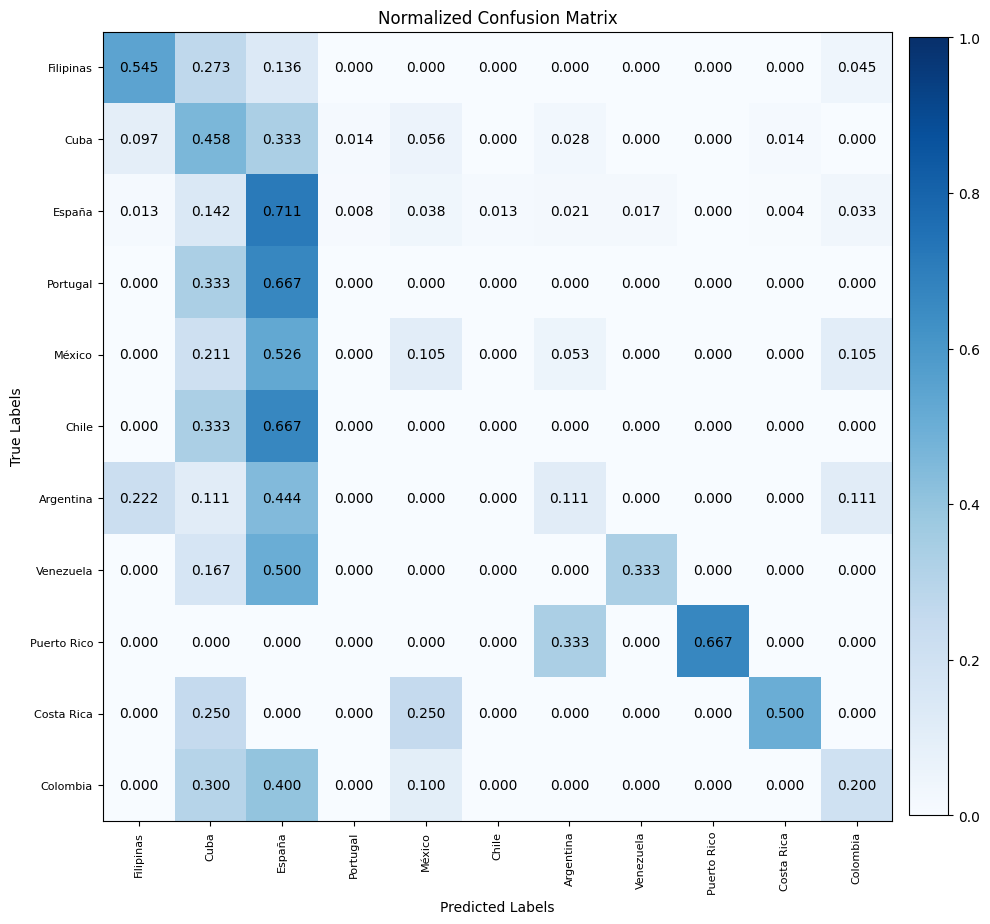

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(mtrx_normal, cmap='Blues', vmin=0, vmax=1)

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')

ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))

# map back to labels
int_to_country = {v: k for k, v in countries_map.items()}
labels = [int_to_country[label] for label in classes]

ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.set_yticklabels(labels, fontsize=8)

# Write normalized values inside cells
for i in range(num_classes):
    for j in range(num_classes):
        value = mtrx_normal[i, j]
        if not np.isnan(value):  # avoid printing if row sum was zero
            ax.text(j, i, f'{value:.3f}', ha='center', va='center', color='black')

plt.colorbar(im, fraction=0.046, pad=0.02)
plt.tight_layout()
plt.show()

In [19]:
weights = model.fc.weight.data.numpy()  # shape: (num_classes, input_dim)
np.savetxt("svm_country_weights.csv", weights, delimiter=",")


In [38]:
print(countries[10])
print(unigrams[1142])

Colombia
cadáver
